In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
matplotlib.rcParams['text.usetex'] = True


In [2]:
def rounded_rect_profile(width, height, radius, resolution=100):
    """
    Generate coordinates for a rounded rectangle with circular corner arcs
    
    Parameters:
    width (float): Width of the rectangle
    height (float): Height of the rectangle
    radius (float): Radius of the corner arcs
    resolution (int): Number of points for each corner arc
    
    Returns:
    tuple: (x, y) coordinates of the rounded rectangle profile
    """
    # Make sure radius isn't larger than half the width or height
    radius = min(radius, width/2, height/2)
    
    # Quarter circles: angles in radians for arcs
    theta = np.linspace(0, np.pi/2, resolution)
    
    # Bottom-left corner (from π to 3π/2)
    bl_x = radius * np.cos(np.pi + theta) + (-width/2 + radius)
    bl_y = radius * np.sin(np.pi + theta) + (-height/2 + radius)
    
    # Bottom-right corner (from 3π/2 to 2π)
    br_x = radius * np.cos(3*np.pi/2 + theta) + (width/2 - radius)
    br_y = radius * np.sin(3*np.pi/2 + theta) + (-height/2 + radius)
    
    # Top-right corner (from 0 to π/2)
    tr_x = radius * np.cos(theta) + (width/2 - radius)
    tr_y = radius * np.sin(theta) + (height/2 - radius)
    
    # Top-left corner (from π/2 to π)
    tl_x = radius * np.cos(np.pi/2 + theta) + (-width/2 + radius)
    tl_y = radius * np.sin(np.pi/2 + theta) + (height/2 - radius)
    
    # Concatenate all parts to form a closed loop
    x = np.concatenate([br_x, tr_x, tl_x, bl_x, [br_x[0]]])  # Add first point at the end to close the loop
    y = np.concatenate([br_y, tr_y, tl_y, bl_y, [br_y[0]]])
    
    return x, y


def square_profile(width, height):
    """Generate coordinates for a simple square/rectangle"""
    x = np.array([-width/2, width/2, width/2, -width/2, -width/2])
    y = np.array([-height/2, -height/2, height/2, height/2, -height/2])
    return x, y

0.2824147815994682 -0.24751279528711337


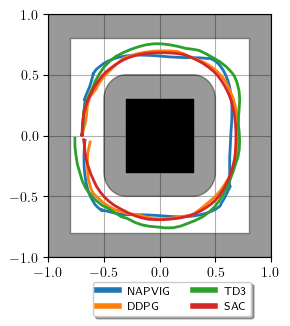

In [3]:
napvig = np.loadtxt('napvig/front35.csv', delimiter=',')[:2040, :][::20]
ddpg1 = np.loadtxt('ddpg/ddpg_1.csv', delimiter=',')[:2000, :][::20]
# ddpg2 = np.loadtxt('ddpg/ddpg_2.csv', delimiter=',')[::20]
td3 = np.loadtxt('td3/td3_2.csv', delimiter=',')[:2050, :][::20]
sac = np.loadtxt('sac/sac_3.csv', delimiter=',')[:2070, :][::20]

offset_x = np.mean(napvig[:,0], axis=0) + 0.1
offset_y = np.mean(napvig[:,1], axis=0)
print(offset_x, offset_y)

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_axisbelow(True)
plt.grid()
# plt.scatter(napvig[:,0]-offset_x, napvig[:,1]-offset_y, s=10)
plt.plot(napvig[:,0]-offset_x, napvig[:,1]-offset_y, linewidth=2)
plt.plot(ddpg1[:,0]-offset_x, ddpg1[:,1]-offset_y, linewidth=2)
# plt.plot(ddpg2[:,0]-offset_x, ddpg2[:,1]-offset_y, linewidth=1)
plt.plot(td3[:,0]-offset_x, td3[:,1]-offset_y, linewidth=2)
plt.plot(sac[:,0]-offset_x, sac[:,1]-offset_y, linewidth=2)

x = np.arange(-0.3, 0.31, 0.05)
y = np.array([0.3] * len(x))
plt.fill_between(x, -y, y, color='k', alpha=1)

# Create the rounded rectangle profile
x_rect, y_rect = rounded_rect_profile(1, 1, 0.2)
plt.fill(x_rect, y_rect, color='k', alpha=0.4)


# Parameters for the second box
inner_width = 1.6
inner_height = 1.6
border_thickness = 0.0 # Thickness of the border

# Generate inner square profile
inner_x, inner_y = square_profile(inner_width, inner_height)

# Generate outer square profile
outer_width = inner_width + 0.4
outer_height = inner_height + 0.4
outer_x, outer_y = square_profile(outer_width, outer_height)

# Create a compound path for the frame (outer square minus inner square)
# The inner path needs to be reversed to make a proper hole
vertices = np.vstack([
    np.column_stack([outer_x, outer_y]),
    np.column_stack([inner_x[::-1], inner_y[::-1]])
])

# Create codes array
n_outer = len(outer_x)
n_inner = len(inner_x)
codes = np.full(n_outer + n_inner, Path.LINETO)
codes[0] = Path.MOVETO  # Start of outer path
codes[n_outer] = Path.MOVETO  # Start of inner path (hole)

# Create path and patch
path = Path(vertices, codes)
patch = PathPatch(path, facecolor='k', alpha=0.4)

# Add patch to axis
ax.add_patch(patch)

plt.ylim([-1., 1.])
plt.xlim([-1., 1.])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xticks([-1, -0.5, 0, 0.5, 1])

plt.tight_layout()

labels = ['NAPVIG', 'DDPG', 'TD3', 'SAC']
leg = fig.legend(labels, loc='upper center', bbox_to_anchor=(.59, 0.06), 
                fancybox=True, shadow=True, ncol=2, prop={'size': 8})

# set the linewidth of each legend object
for legobj in leg.legend_handles:
    legobj.set_linewidth(4.0)

plt.savefig('arena_trajectories.pdf', bbox_inches="tight")